# Numerics 1: Homework 01
## Cooper Simpson

## Setup

Here we have setup our notebook by importing neccessary modules and defining our various root finding methods that we will use throughout.

In [61]:
%%capture
!jt -r

Reset css and font defaults in:
/home/rs-coop/.jupyter/custom &
/home/rs-coop/.local/share/jupyter/nbextensions


In [1]:
#Change theme
from jupyterthemes import jtplot
!jt -t grade3
jtplot.style()

In [63]:
#Imports
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
sns.set()

In [76]:
#Root finding class with different methods
class RootFinder():
    data = {}
    
    def __init__(self, tolerance=1E-4, max_iterations=1000):
        self.tolerance = tolerance
        self.max_iter = max_iterations
      
    #Clean up any member vars
    def clean(self):
        self.data = {}
    
    def addData(self, method, p, iterations):
        self.data[method] = {'sequence':p, 'iterations':iterations}
        
    def fmtTable(self, start, end):
        table = {}
        iterations = []
        
        for method in self.data:
            table[method] = self.data[method]['sequence']
            iterations.append(self.data[method]['iterations'])
            
        df = pd.DataFrame.from_dict(table, orient='index')
        df['Iterations'] = iterations
        
        return df.iloc[:, list(range(start)) + list(range(-end, 0))]
    
    def fmtTable_single(self, method):
        table = {}
        table['Root Estimate'] = self.data[method]['sequence']
        
        df = pd.DataFrame(table)
        
        return df
    
    def fmtTable_bisection(self):
        table = {}
        table['c'] = self.data['bisection']['sequence']
        table['a'] = [a for a,b in self.ab]
        table['b'] = [b for a,b in self.ab]
        
        df = pd.DataFrame(table)
        
        return df
        

    #Root finding methods...
    
    def bisection(self, a, b, f, *, ab_save=False):
        p = []
        ab = []
        iterations = 0
        
        c_old = None
        c_new = (a+b)/2
        p.append(c_new)
        ab.append((a, b))

        while True:
            
            iterations += 1
            fval = f(c_new)
            
            if np.sign(f(a)) + np.sign(fval) == 0:
                b = c_new
            elif np.sign(fval) + np.sign(f(b)) == 0:
                a = c_new
            else:
                if fval == 0: break
                
                raise Exception('Root is not bounded by initial guess.')
                
            c_old = c_new
            c_new = (a+b)/2
            p.append(c_new)
            ab.append((a, b))
            
            if np.abs((c_new-c_old)/c_old) <= self.tolerance or iterations>=self.max_iter:
                break

        self.addData('bisection', p, iterations)
        
        if ab_save:
            self.ab = ab
           
        return c_new
    
    def FPI(self, p0, g):
        p = []
        iterations = 1
        
        p.append(p0)
        p_new = g(p0)
        p.append(p_new)
        
        while np.abs((p_new-p0)/p0) > self.tolerance and iterations<self.max_iter:
            iterations += 1
            
            p0 = p_new
            p_new = g(p0)
            p.append(p_new)
            
        self.addData('fixed point iteration', p, iterations)
        
        return p_new

    def newton(self, p0, f, df):
        p = []
        iterations = 1
    
        p.append(p0)
        p_new = p0 - f(p0)/df(p0)
        p.append(p_new)
        
        while np.abs((p_new-p0)/p0) > self.tolerance and iterations<self.max_iter:
            iterations += 1
            
            p0 = p_new
            p_new = p0 - f(p0)/df(p0)
            p.append(p_new)
            
        self.addData('newton-raphson', p, iterations)
        
        return p_new

    def false_pos(self, p0, p1, f):
        p = []
        iterations = 0
        
        p.append(p0)
        p.append(p1)
        
        while np.abs((p1-p0)/p0) > self.tolerance and iterations<self.max_iter:
            iterations += 1
            
            temp = p1 - (f(p1)*(p1-p0))/(f(p1)-f(p0))
            p0 = p1
            p1 = temp
            p.append(p1)
            
        self.addData('false position', p, iterations)
        
        return p1

In [65]:
#Plot a spider web for given function and convergance sequence
def spider(f, seqs, *, fsize=(10,10), pad=2, step=0.1):
    fig, ax = plt.subplots(1,len(seqs),figsize=fsize)
    
    for i,seq in enumerate(seqs):
        xmax = max(seq)+pad
        xmin = min(seq)-pad
        x = np.arange(xmin, xmax, step)
        
        if len(seqs)>1:
            axes = ax[i]
        else:
            axes = ax

        axes.plot(x, f(x))
        axes.plot(x,x)

        last = (seq[0],0)
        for p in seq:
            val = f(p)

            axes.plot([last[0],p], [last[1],val], c='r')
            axes.plot([p,val], [val,val], c='r')
            last = (val, val)

        axes.set_xlim(xmin, xmax)
        axes.set_title('Spider Web Diagram: Initial Guess @%s' % (seqs[i][0]))
        
    return fig

In [26]:
#Testing above code
def f(x):
    return x + np.exp(x)

def df(x):
    return 1 + np.exp(x)

rf = RootFinder()
print(rf.newton(, f, df))
print(rf.data['newton-raphson']['iterations'])
print('First: %s, Last: %s' % (rf.data['newton-raphson']['sequence'][0], rf.data['newton-raphson']['sequence'][-1]))

-0.5671432903796383
3
First: -2, Last: -0.5671432903796383


## Problem 1
Find the root of $ f(x)=x + e^x $ within $10^{-4}$ using Bisection, Fixed Point Iteration, Newton-Raphson, and False Position.

We first define our tolerance and our initial guesses, where we have a guess left of the root and a guess to the right of the root. If only one guess is needed we default to the left side guess. We also define the functions we need including the function itself, its derivative, and our $g(x)=x$ for fixed point iteration.

In [24]:
#Defining things
tol = 1E-4 #Success tolerance
lg = -2 #Left side guess when applicable
rg = 0 #Right side guess when applicable

def f(x):
    return x + np.exp(x)

def df(x):
    return 1 + np.exp(x)

def g(x):
    return -np.exp(x)

In [26]:
%%capture
#Running things
rf = RootFinder(tolerance=tol)
rf.bisection(lg, rg, f)
rf.FPI(lg, g)
rf.newton(lg, f, df)
rf.false_pos(lg, rg, f)

In [27]:
#Outputting things
df = rf.fmtTable(6, 6)
display(df)

,0,1,2,3,4,5,15,16,17,18,19,Iterations
bisection,-1.0,-0.500000,-0.750000,-0.62500,-0.562500,-0.593750,-0.567169,NaN,NaN,NaN,NaN,15
fixed point iteration,-2.0,-0.135335,-0.873423,-0.41752,-0.658678,-0.517535,-0.566970,-0.567242,-0.567087,-0.567175,-0.567125,19
newton-raphson,-2.0,-0.357609,-0.558708,-0.56713,-0.567143,NaN,NaN,NaN,NaN,NaN,NaN,4
false position,-2.0,0.000000,-0.698162,-0.58148,-0.566811,-0.567144,NaN,NaN,NaN,NaN,NaN,5


In the table above we can see, for each root finding method, the sequence of root estimates and the total number of iterations required to converge within $10^{-4}$. Note that *NaN* indicates that at that point the sequence had already converged; for example Newton-Raphson converges after only four iterations and thus has no sequence values after that point. Also note that the table jumps from index 5 to index 15. This is becuase of the large difference in iterations between some of the methods, so some of the middle sequence values were left out for readability. All methods used the same initial guess to the extent where that makes sense, so the 0th sequence value for bisection is -1 instead of -2 because that is the initial midpoint.

In general we see that all methods converge to approximately the same root value of $\boxed{-0.5671}$. Newton-Raphson was the fastest with 4 iterations, while False Position was close behind with 5. Bisection took much longer at 15 iterations, and Fixed Point Iteration took the longest with 19.

## Problem 2
Use the Bisection method to find approximations within $10^{-4}$

### a).
Find first positive root of $x=tan(x)$. 

We will consider the function $tan(x)-x$ and look for the first positve zero. We know that $tan(0)=0$, but because we are looking for the first *positive* value we need to look past this. We also know that $tan$ has vertical asympototes at odd multiples of $\frac{\pi}{2}$. Thus we will take our initial our left hand guess just to the right of $\frac{\pi}{2}$ and our right hand guess just to the left of $\frac{3\pi}{2}$

In [28]:
#Defining and running things
def f(x):
    return np.tan(x) - x

lg = np.pi/2 + 0.1
rg = 3*np.pi/2 - 0.1

rf = RootFinder(tolerance=1E-4)
root = rf.bisection(lg, rg, f, ab_save=True)

In [31]:
#Outputting things
print('Root:%f, f(%f)=%f' % (root, root, f(root)))
df = rf.fmtTable_bisection()
display(df.transpose())

Root:4.493533, f(4.493533)=0.002498


,0,1,2,3,4,5,6,7,8,9,10,11,12
c,3.141593,3.876991,4.244690,4.428539,4.520464,4.474502,4.497483,4.485992,4.491738,4.494610,4.493174,4.493892,4.493533
a,1.670796,3.141593,3.876991,4.244690,4.428539,4.428539,4.474502,4.474502,4.485992,4.491738,4.491738,4.493174,4.493174
b,4.612389,4.612389,4.612389,4.612389,4.612389,4.520464,4.520464,4.497483,4.497483,4.497483,4.494610,4.494610,4.493892


In the table above we see values for the left and right a and b values as well as the midpoint c. We see that the Bisection method converges to a root value of $\boxed{4.493533}$ indicated by the c value after 12 iterations.

### b).
Find an approximation to $25^{1/3}$.

We will consider the function $25-x^3$ which clearly has a root at our desired value of $25^{1/3}$, so finding this root will give us our approximation. We know the square root of 25 is 5 giving us an upper bound on our guesses, so we will take our initial guesses as 1 and 5 with our root somewhere in between.

In [66]:
#Defining and running things
def f(x):
    return 25-x**3

lg = 1
rg = 5

rf = RootFinder(tolerance=1E-4)
root = rf.bisection(lg, rg, f, ab_save=True)

In [67]:
#Outputting things
print('Root:%f, Numpy:%f' % (root, np.cbrt(25)))
df = rf.fmtTable_bisection()
display(df.transpose())

Root:2.924072, Numpy:2.924018


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
c,3.0,2.0,2.5,2.75,2.875,2.9375,2.90625,2.921875,2.929688,2.925781,2.923828,2.924805,2.924316,2.924072
a,1.0,1.0,2.0,2.50,2.750,2.8750,2.87500,2.906250,2.921875,2.921875,2.921875,2.923828,2.923828,2.923828
b,5.0,3.0,3.0,3.00,3.000,3.0000,2.93750,2.937500,2.937500,2.929688,2.925781,2.925781,2.924805,2.924316


In the table above we see values for the left and right a and b values as well as the midpoint c. We see that the Bisection method converges to a root value of $2.924072$ indicated by the c value after 13 iterations. Thus we can conclude that $\boxed{25^{\frac{1}{3}} \approx 2.924072}$

## Problem 3
Use Fixed Point Iteration to find a solution of $2sin(\pi x) + x = 0$ in $[1,2]$. Use an initial guess of $p_0=1$, and get an answer accurate within $10^{-2}$.

To use fixed point iteration we must first transform our function into $g(x)=x$. While this looks straightforward, the naive approach will cause problems. For this reason we will let $g(x)=\frac{2sin(\pi x) + 4x}{3}$, and we will discuss why this is necessary later.

In [72]:
#Defining and running things
def g(x):
    return (2*np.sin(np.pi*x) + 4*x)/3

rf = RootFinder(tolerance=1E-2)
root = rf.FPI(1, g)

Root: 1.207989, f(1.207989)=-0.007817


,0,1,2,3
Root Estimate,1.0,1.333333,1.200428,1.207989


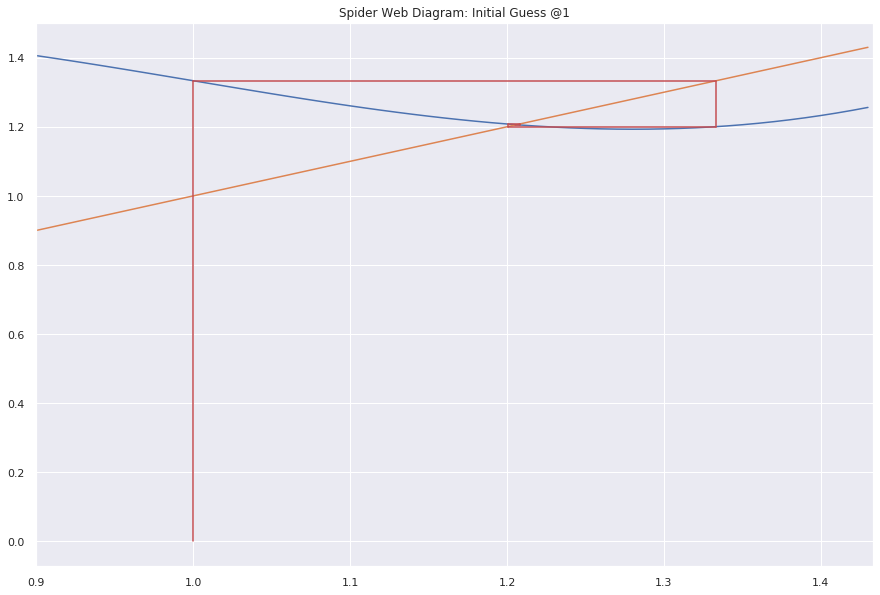

In [73]:
#Outputting things
print('Root: %f, f(%f)=%f' % (root, root, 2*np.sin(np.pi*root)+root))
df = rf.fmtTable_single('fixed point iteration')
display(df.transpose())
fig = spider(g, [rf.data['fixed point iteration']['sequence']], pad=0.1, step=0.01, fsize=(15,10))

We can see in the figure above that Fixed Point Iteration converged on a root value of $\boxed{1.20}$ which is also shown in the spider web graph. Had we tried to use $g_0(x)=-2sin(\pi x)$ we would not have been able to converge to the root. This is because for the root $p\approx1.20$, $|g_0'(p)|\approx5$ while $|g'(p)|\approx0.4$. While this magnitude constraint is not necessary for convergance (it is sufficient), it does help to explain the problems in the naive approach.

## Problem 4

### a).
The iteration equation for the Secant root finding method can be written in multiple forms. The standard form is given below:
$$ x_{n} = x_{n-1} - \frac{f(x_{n-1})(x_{n-1}-x_{n-2})}{f(x_{n-1})-f(x_{n-2})}$$
However, this can also be written in a simpler form given below:
$$ x_n = \frac{f(x_{n-1})x_{n-2}-f(x_{n-2})x_{n-1}}{f(x_{n-1})-f(x_{n-2})} $$

This latter form is likely to be less accurate than the standard form due to the numerical faults of machine precision. In both cases we see that we are computing $f(x_{n-1})-f(x_{n-2})$ which can be very close to each other numerically (especially as we approach convergence). As well, in the numerator in both cases we are subtracting numbers that are almost identical. Because of this we break two fundamental rules: subtracting almost identical numbers, and dividing by values close to zero.

The important thing that makes the simplified form less numerically stable is the fact that all of these rules are broken within the fraction that computes our new root estimate. This will give a very inaccurate update. However, in the standard form this fraction is subtracted from the original root estimate making it much more numerically stable. It is this small update to a value as opposed to an error filled update that makes the simplified version less accurate.

### b).
Use Newtons method with the ordinary annuity equation to find the maximal interest rate a borrower can afford to pay for a 30 year mortgage on 135,000 paying 1,000 per month.
$$ A=\frac{P}{i}[1-(1+i)^{-n}]$$

In the equation above $A=135000$ is the mortgage amount, $P=1000$ is the payment amount, and $n=30*12$ is the number of payment periods. We are curious about the parameter $i$ indicating the interest rate per period -- which in this case is interest rate per month.

We will look at the equation $\frac{P}{i}[1-(1+i)^{-n}]-A$ which has the derivative (necessary for Newtons method) of...
$$ \frac{P}{i^2}[in(1+i)^{-n-1}-(1-(1+i)^{-n}] $$

In [74]:
#Defining and running things
A=135000
P=1000
n=30*12

def f(i):
    return (P/i)*(1-(1+i)**(-n)) - A

def df(i):
    return (P/i**2)*(i*n*(1+i)**(-n-1) - (1-(1+i)**(-n)))

p0 = 0.001

rf = RootFinder(tolerance=1E-8)
root = rf.newton(p0, f, df)

In [75]:
#Outputting things
print('Root:%f, f(%f)=%f' % (root, root, f(root)))
df = rf.fmtTable_single('newton-raphson')
display(df.transpose())

Root:0.006750, f(0.006750)=0.000000


,0,1,2,3,4,5,6
Root Estimate,0.001,0.004263,0.006221,0.006724,0.00675,0.00675,0.00675


We can see that the maximal interest rate the borrower can afford to pay is $\boxed{0.006750}$ per month. This was calculated by searching for the root of our ordinary annuity equation with respect to the variable $i$. An interest rate lower than this and the mortgage could be paid off faster, but an interest rate higher than this would mean the mortgage could not be paid off by the end of the period.

## Problem 5
Use Fixed Point Iteration to explore the convergance characterstics for $f(x)=(x+1)(x-3)$ with $x=g(x)=\frac{x^2-3}{2}$ relative to the magnitude of $g'$ near each of the roots.

In [48]:
#Defining things
def f(x):
    return (x+1)*(x-3)

def g(x):
    return (x**2-3)/2

def mag_dg(x):
    return np.abs(x)

It is clear to see that our function has two roots: one at $x=-1$ and the other at $x=3$. We will first explore the convergence characteristics for the root at $x=-1$.

In [49]:
#Runnning things
rf = RootFinder(max_iterations=2000)
root1 = rf.FPI(-2, g)
seq1 = rf.data['fixed point iteration']['sequence']

rf.clean()

root2 = rf.FPI(0.5, g)
seq2 = rf.data['fixed point iteration']['sequence']

Root1: -1.031245, Root2: -0.968266


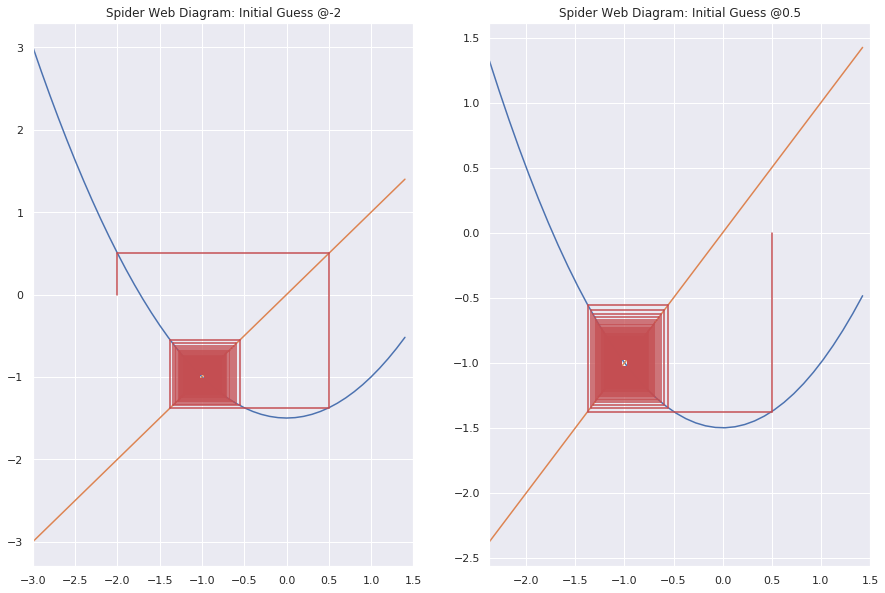

In [50]:
#Outputting things
print("Root1: %f, Root2: %f" % (root1, root2))
fig = spider(g, [seq1, seq2], fsize=(15,10), pad=1)

Looking at the magnitude of the derivative we see that $|g'(-1)|=1$, so because we know Fixed Point Iteration will converge if $|g'(p)<1|$ near the root $p$ we have a chance of converging to the root. This is validated by the figures seen above -- for initial guesses to the left and right of the root. We see that the algorithm is getting closer and closer to converging to the root, and given enough time it would likely converge within any bound. I have limited the max number of iterations, but we can see that the algorithm enters a slowly decaying orbit around the root. Altogether we see that Fixed Point Iteration will converge in this case, but because the magnitude of the derivative is 1 it will be a slow convergance.

We next examine the convergence characteristics for the root at $x=3$.

In [51]:
#Runnning things
rf = RootFinder(max_iterations=2)
root1 = rf.FPI(4, g)
seq1 = rf.data['fixed point iteration']['sequence']

rf = RootFinder(max_iterations=2000)

root2 = rf.FPI(2.5, g)
seq2 = rf.data['fixed point iteration']['sequence']

Root1: 19.625000, Root2: -0.968217


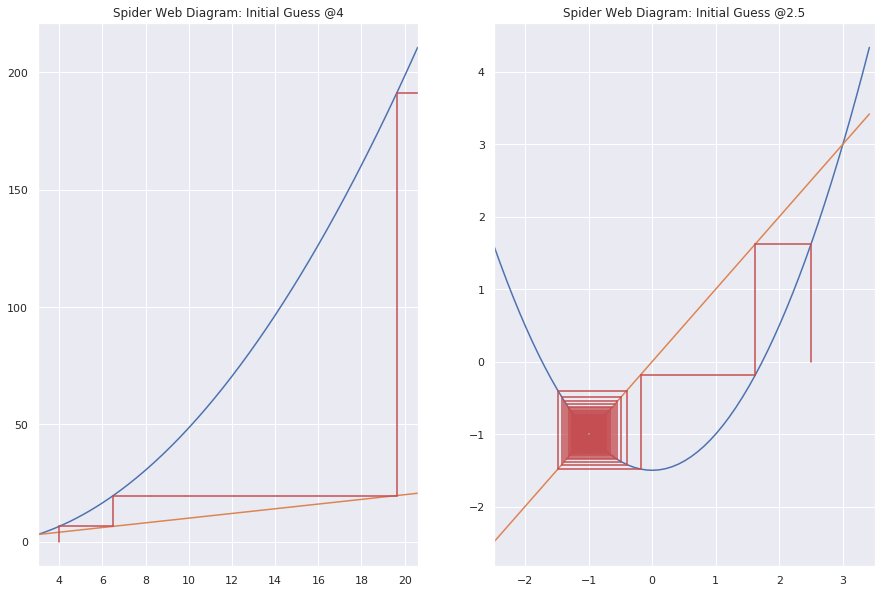

In [52]:
#Outputting things
print('Root1: %f, Root2: %f' % (root1, root2))
fig = spider(g, [seq1, seq2], fsize=(15,10), pad=1)

We first note that in this case we have $|g'(3)|=3$ which is most certainly not less than 1. Thus we expect that Fixed Point Iteration will not be able to converge to this root. This is validated by the plots we see immediately above. On the left we see a spider diagram for an initial guess to the right of the root -- this quickly diverges. On the right we see a spider diagram for an initial guess to the left of the root. This will converge, but it will converge to the the root at $x=-1$. Thus we see that Fixed Point Iteration is unable to converge to the root at $x=3$ no matter the initial guess becuase the magnitude of its first derivative near the root is too large.